# Handwritten Document Conversion

July 19, 2024

## Setup Env

In [5]:
!python --version

Python 3.11.8


### Install packages

```bash
pip install layoutparser
pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
```

Layout parse -> 1. Text detection and 2. Layout detection

### Import modules

In [6]:
import layoutparser as lp
import numpy as np
import pandas as pd
import cv2 as cv
import pathlib
import os
import requests
import copy
import pytesseract
from PIL import Image
from layoutparser.models.detectron2 import catalog
from matplotlib import pyplot as plt
from random import randrange

In [7]:
def load_model(config_path: str='lp://<dataset_name>/<model_name>/config', extra_config=None):
    config_path_split = config_path.split('/')
    dataset_name = config_path_split[-3]
    model_name = config_path_split[-2]

    # get the URLs from the MODEL_CATALOG and the CONFIG_CATALOG 
    # (global variables .../layoutparser/models/detectron2/catalog.py)
    model_url = catalog.MODEL_CATALOG[dataset_name][model_name]
    config_url = catalog.CONFIG_CATALOG[dataset_name][model_name]

    # override folder destination:
    if 'model' not in os.listdir():
        os.mkdir('model')

    config_file_path, model_file_path = None, None

    for url in [model_url, config_url]:
        filename = url.split('/')[-1].split('?')[0]
        save_to_path = f"model/" + filename
        if 'config' in filename:
            config_file_path = copy.deepcopy(save_to_path)
        if 'model_final' in filename:
            model_file_path = copy.deepcopy(save_to_path)

        # skip if file exist in path
        if filename in os.listdir("model"):
            continue
        # Download file from URL
        r = requests.get(url, stream=True, headers={'user-agent': 'Wget/1.16 (linux-gnu)'})

        with open(save_to_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=4096):
                if chunk:
                    f.write(chunk)

    # load the label map
    label_map = catalog.LABEL_MAP_CATALOG[dataset_name]

    return lp.models.Detectron2LayoutModel(
        config_path=config_file_path,
        model_path=model_file_path,
        label_map=label_map,
        extra_config=extra_config
    ), model_name

### Import dset

Dataset description.

In [8]:
dset=pathlib.Path.home().joinpath('projects/Handwritten-Document-Conversion/data')
test=dset.joinpath('test')
test

PosixPath('/home/nikin/projects/Handwritten-Document-Conversion/data/test')

In [9]:
images = [cv.cvtColor(cv.imread(test.joinpath(img).as_posix()), cv.COLOR_BGR2RGB) for img in test.iterdir()]

## Modeling

> [Layout Parser Model Zoo](https://layout-parser.readthedocs.io/en/latest/notes/modelzoo.html7)

The config path of a spectrum of pre-trained models trained on different dataset are stored in `modelzoo.txt`

In [10]:
with open('./zoo.txt', 'r') as zoo:
    config_path = [line.rstrip('\n') for line in zoo]

### Initiate Detectron2LayoutModel and parse the image

In [11]:
def parseLayout(image, config_path, extra_config=None):
    model, name = load_model(config_path, extra_config=extra_config)
    layout=model.detect(image)
    color_map = { 'Text': 'red', 'Title': 'blue', 'List': 'green', 'Table': 'purple', 'Figure': 'pink' }
    output = lp.visualization.draw_box(canvas=image, layout=layout, box_width=10, color_map=color_map)
    output.save("./layout.png")
    plt.imshow(output)
    plt.axis('off')
    return layout, name

95


(-0.5, 984.5, 1298.5, -0.5)

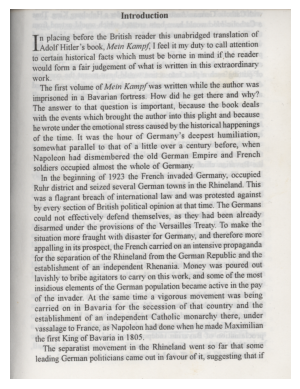

In [16]:
## Specify an image whose layout is to be parsed
randIndex = randrange(0, len(images)); print(randIndex)
# img = images[27]
img=cv.imread(test.joinpath('x.png').as_posix())
# Change to RGB
img = img[..., ::-1]
plt.imshow(img)
plt.axis('off')

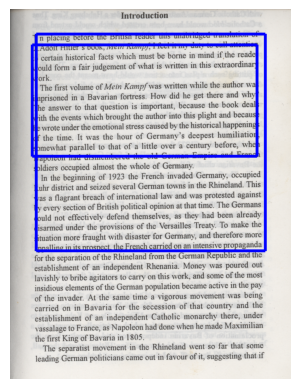

In [17]:
# Specify the model and parse
model = config_path[3]
threshold = 0.7
layout, model_name = parseLayout(img, model, ["MODEL.ROI_HEADS.SCORE_THRESH_TEST", threshold])

It's more desirable that individual paragraphs are detected. So Let's run another model.

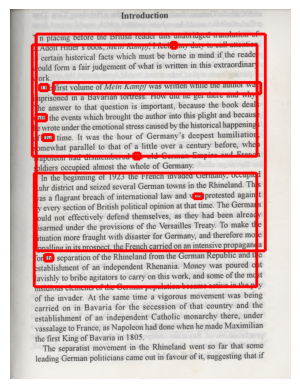

In [18]:
# Specify the model and parse
model = config_path[1]
threshold = 0.5
layout, model_name = parseLayout(img, model, ["MODEL.ROI_HEADS.SCORE_THRESH_TEST", threshold])

Let's try to extract the text from the detected layouts.

### Initiate Tesseract OCR Engine and try to extract text

Ensure tesseract is installed system-wide.

In [ ]:
!which tesseract

In [19]:
ocr_agent = lp.TesseractAgent(languages='eng')

In [20]:
def extract_text(image, b, padding=None):
    boundary = [b.block.x_1, b.block.y_1, b.block.x_2, b.block.y_2]
    # TODO optimize the padding parameter like CSS
    if padding:
        boundary = [item + padding for item in boundary]
    left, top, right, bottom = map(int, boundary)
    cropped_image = img[top:bottom, left:right]
    extracted_text =  ocr_agent.detect(cropped_image)
    return cropped_image, extracted_text

In [21]:
blocks = [b for b in layout]
for i, block in enumerate(blocks):
        print(block.type, i)

Page Frame 0
Page Frame 1
Other 2
Other 3
Row 4
Other 5
Other 6
Page Frame 7
Other 8
Other 9
Other 10


(-0.5, 801.5, 761.5, -0.5)

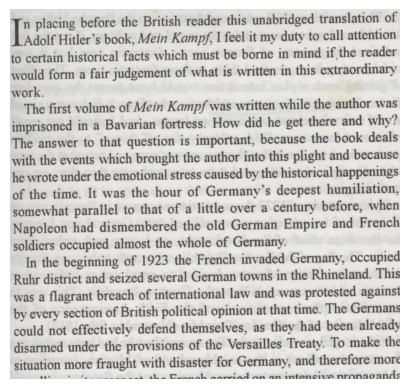

In [22]:
frame, extracted_text = extract_text(img, blocks[0], padding=-16)
plt.imshow(frame)
plt.axis('off')

In [23]:
print(extracted_text)

In placing before the British reader this unabridged translation of
Adolf Hitler’s book, Mein Kampf, 1 feel it my duty to call attention
to certain historical facts which must be borne in mind if the reader
would form a fair judgement of what is written in this extraordinary
work.

The first volume of Mein Kampf was written while the author was
imprisoned in a Bavarian fortress. How did he get there and why?
The answer to that question is important, because the book deals
with the events which brought the author into this plight and because
he wrote under the emotional stress caused by the historical happenings
of the time. It was the hour of Germany’s deepest humiliation,
somewhat parallel to that of a little over a century before, when
Napoleon had dismembered the old German Empire and French
soldiers occupied almost the whole of Germany.

In the beginning of 1923 the French invaded Germany, occupied
Ruhr district and seized several German towns in the Rhineland. This
was a flagrant 

* Tesseract works well with scanned images of **printed text**. So, **as long as a proper layout is
being detected**, tesseract's OCR can be used for text extraction.

* However, tesseract does not perform very well on images of handwritten text. Below is an example.

(-0.5, 799.5, 417.5, -0.5)

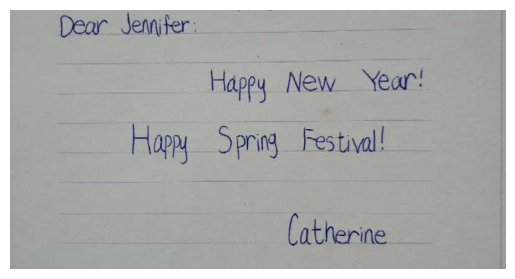

In [69]:
img=cv.imread(test.joinpath('y.jpg').as_posix())
img = img[..., ::-1]
plt.imshow(img)
plt.axis('off')

In [70]:
print(ocr_agent.detect(img))

Dear Jemifer:
Hapfg New Year:
Hoppy  Spring Festival

(atherine



The result in the above image is still not bad; beacuse the handwriting is 
rather clear and non-cursive. Let's try on another image.

(-0.5, 3999.5, 2999.5, -0.5)

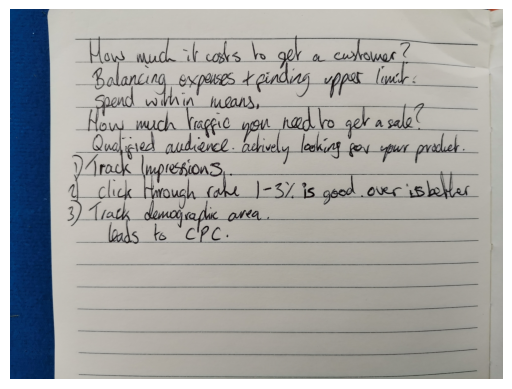

In [81]:
img=images[28]
plt.imshow(img)
plt.axis('off')

In [82]:
print(ocr_agent.detect(img))

: | gL ﬁ : ._.

- | / VAN , =
'j,&’ W (0 : ‘ - S

O 14

1 . p e
, X (< lA A () (

%1% 416 C

g
LA




In [ ]:
def log():
    with open('./performance.csv', 'a+') as performance:
        content = f"{model_name},{threshold}\n"
        performance.write(content)

In [ ]:
log()

## Performance